Install GTSAM library

In [ ]:
! pip3 install gtsam imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 27.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import math
import gtsam.utils.plot as gtsam_plot
from IPython.display import Image
import imageio
import os

Recover visual odometry using optical flow version 1, batch solution



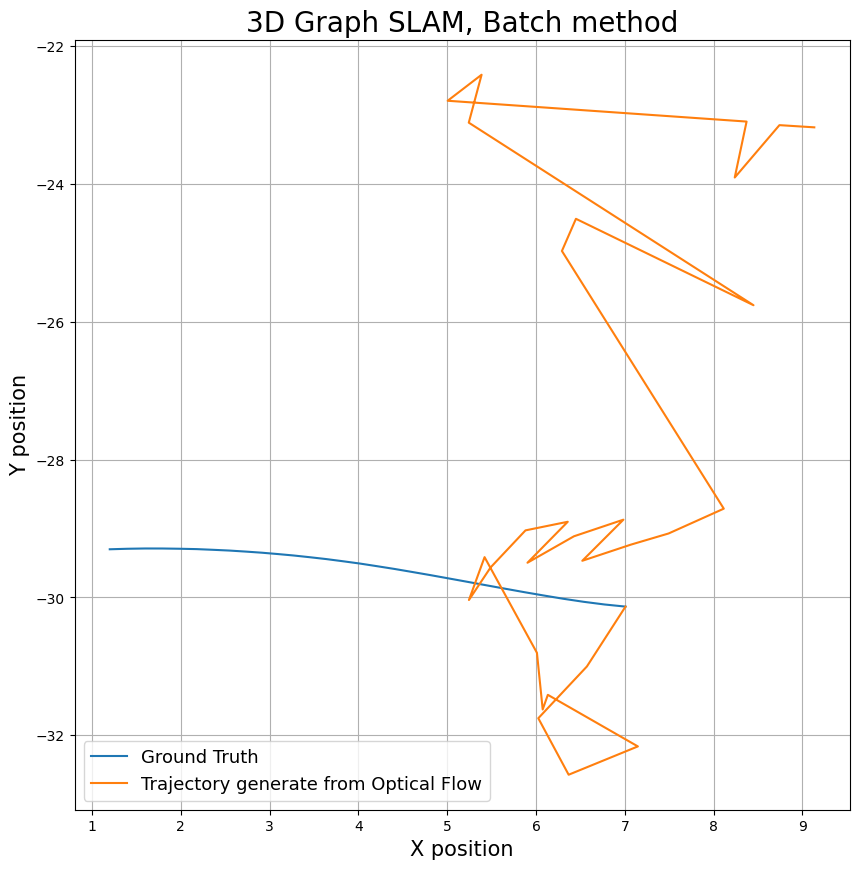

In [ ]:
###CHATGPT
# Create the graph
import numpy as np
import cv2
graph = gtsam.NonlinearFactorGraph()
poses = np.loadtxt('/content/drive/MyDrive/data/pose_left.txt')

# Add a Gaussian prior on pose x_1
R0 = gtsam.Rot3.Quaternion(poses[0,6], poses[0,3], poses[0,4], poses[0,5])
t0 = gtsam.Point3(poses[0,0], poses[0,1], poses[0,2])
priorMean = gtsam.Pose3(R0, t0)
priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))  # 30cm std on x,y,z. 0.1 rad on all angles
graph.add(gtsam.PriorFactorPose3(0, priorMean, priorNoise))
K = np.array([[320, 0, 320],
              [0, 320, 240],
              [0, 0, 1]])

# Load images and flow data
flow = np.load('/content/drive/MyDrive/data/flow_dd.npy')  # assumes flow data is stored in .flo format

# Add odometry factors
for i in range(29):
    m = i
    n = i+1
    du = flow[i, :, :, 0]/480
    dv = flow[i, :, :, 1]/640
    pts1 = np.vstack((du.flatten(), dv.flatten()))
    pts2 = pts1 + np.array([[1], [0]])  # create second set of points shifted by (1, 0)

    # Compute essential matrix using eight-point algorithm
    pts1_norm = np.linalg.inv(K) @ np.vstack((pts1, np.ones((1, pts1.shape[1]))))
    pts2_norm = np.linalg.inv(K) @ np.vstack((pts2, np.ones((1, pts2.shape[1]))))
    E, _ = cv2.findEssentialMat(pts1_norm[:2].T, pts2_norm[:2].T, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Ensure essential matrix satisfies constraint on singular values
    U, S, Vt = np.linalg.svd(E)
    S = np.array([1, 1, 0])
    E = U @ np.diag(S) @ Vt

    # Recover relative camera pose from essential matrix
    retval, R, t, _ = cv2.recoverPose(E, pts1_norm[:2].T, pts2_norm[:2].T, K)
    Rodo = gtsam.Rot3(R)
    odometry = gtsam.Pose3(Rodo,t)
    odometryNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
    graph.add(gtsam.BetweenFactorPose3(m, n, odometry, odometryNoise))

# Initialize to noisy points
initialEstimate = gtsam.Values()

for i in range(30):
    R = gtsam.Rot3.Quaternion(poses[i,6], poses[i,3], poses[i,4], poses[i,5])
    t = gtsam.Point3(poses[i,0], poses[i,1], poses[i,2])
    initialEstimate.insert(i, gtsam.Pose3(R, t))

optimizer = gtsam.GaussNewtonOptimizer(graph, initialEstimate)

result = optimizer.optimizeSafely()

optimal_poses = gtsam.utilities.extractPose3(result)
fig = plt.figure(figsize=(10,10))
plt.plot(poses[0:30,0],poses[0:30,1])
plt.plot(optimal_poses[:,9], optimal_poses[:,10])
plt.xlabel("X position", fontsize = 15)
plt.ylabel("Y position", fontsize = 15)

plt.title('3D Graph SLAM, Batch method', fontsize = 20)
plt.legend(['Ground Truth', 'Trajectory generate from Optical Flow'], fontsize = 13, loc='lower left')
plt.grid()
plt.show()


Recover visual odometry using optical flow version 2, batch solution

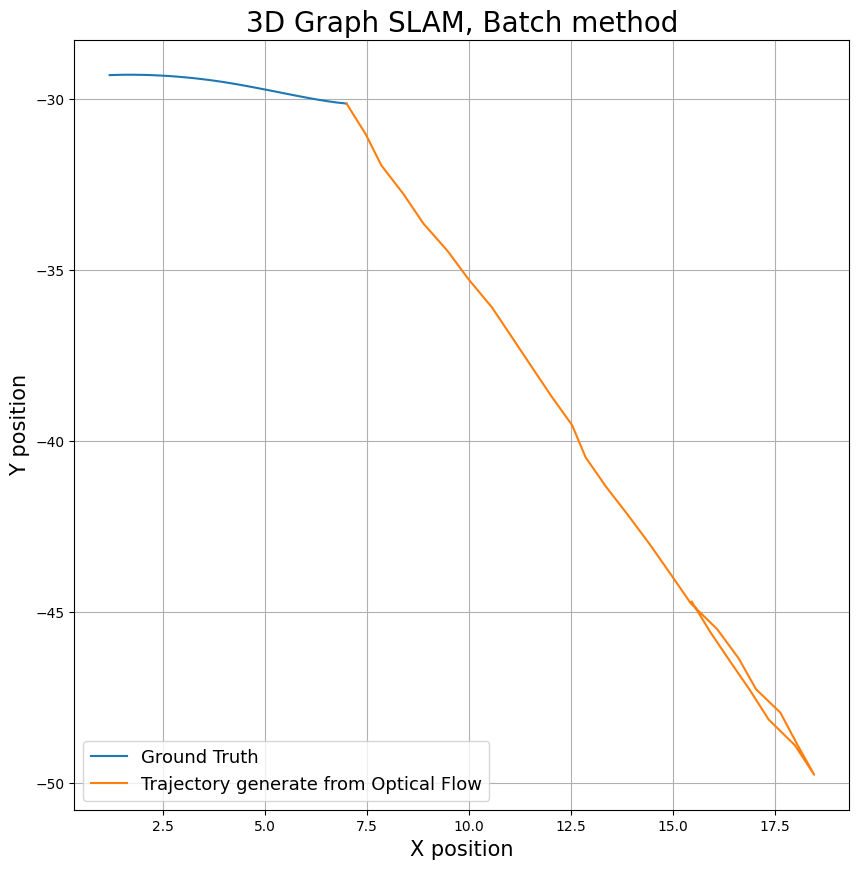

In [ ]:
###ARAVIND
# Create the graph
import numpy as np
import cv2
graph = gtsam.NonlinearFactorGraph()
poses = np.loadtxt('/content/drive/MyDrive/data/pose_left.txt')


# Add a Gaussian prior on pose x_1
R0 = gtsam.Rot3.Quaternion(poses[0,6], poses[0,3], poses[0,4], poses[0,5])
t0 = gtsam.Point3(poses[0,0], poses[0,1], poses[0,2])
priorMean = gtsam.Pose3(R0, t0)
priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))  # 30cm std on x,y,z. 0.1 rad on all angles
graph.add(gtsam.PriorFactorPose3(0, priorMean, priorNoise))
K = np.array([[320, 0, 320],
              [0, 320, 240],
              [0, 0, 1]])

# Load images and flow data
odom = np.loadtxt('/content/drive/MyDrive/data/odom.txt')

# Add odometry factors
for i in range(29):
    m = i
    n = i+1
    R = np.array([odom[i,0],odom[i,1],odom[i,2],odom[i,3],odom[i,4],odom[i,5],odom[i,6],odom[i,7],odom[i,8]]).reshape(3,3)
    t = gtsam.Point3(odom[i,9],odom[i,10],odom[i,11])
    Rodo = gtsam.Rot3(R)
    odometry = gtsam.Pose3(Rodo,t)

    odometryNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

    graph.add(gtsam.BetweenFactorPose3(m, n, odometry, odometryNoise))

# Initialize to noisy points
initialEstimate = gtsam.Values()

for i in range(30):
    R = gtsam.Rot3.Quaternion(poses[i,6], poses[i,3], poses[i,4], poses[i,5])
    t = gtsam.Point3(poses[i,0], poses[i,1], poses[i,2])
    initialEstimate.insert(i, gtsam.Pose3(R, t))


optimizer = gtsam.GaussNewtonOptimizer(graph, initialEstimate)

result = optimizer.optimizeSafely()

optimal_poses = gtsam.utilities.extractPose3(result)
fig = plt.figure(figsize=(10,10))
plt.plot(poses[0:30,0],poses[0:30,1])
plt.plot(optimal_poses[:,9], optimal_poses[:,10])
plt.xlabel("X position", fontsize = 15)
plt.ylabel("Y position", fontsize = 15)

plt.title('3D Graph SLAM, Batch method', fontsize = 20)
plt.legend(['Ground Truth', 'Trajectory generate from Optical Flow'], fontsize = 13, loc='lower left')
plt.grid()
plt.show()


Recover visual odometry using optical flow version 3, batch solution


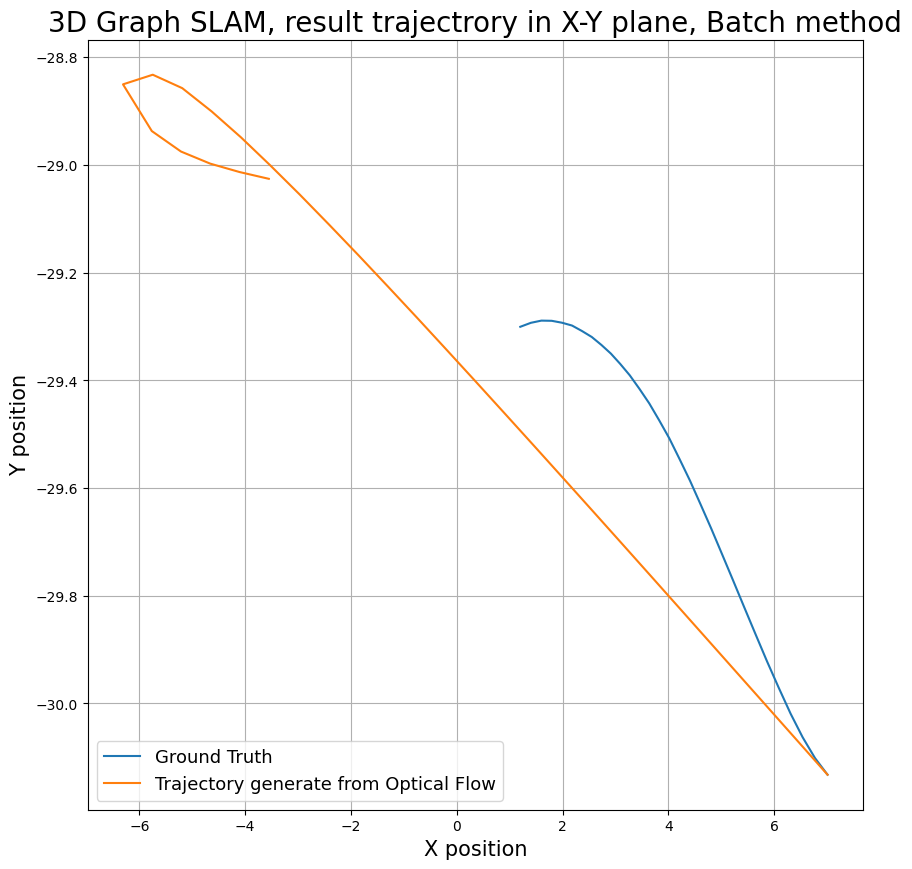

In [ ]:
###Siyuan
# Create the graph
import numpy as np
import cv2
graph = gtsam.NonlinearFactorGraph()
poses = np.loadtxt('/content/drive/MyDrive/data/pose_left.txt')


# Add a Gaussian prior on pose x_1
R0 = gtsam.Rot3.Quaternion(poses[0,6], poses[0,3], poses[0,4], poses[0,5])
t0 = gtsam.Point3(poses[0,0], poses[0,1], poses[0,2])
priorMean = gtsam.Pose3(R0, t0)
priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))  # 30cm std on x,y,z. 0.1 rad on all angles
graph.add(gtsam.PriorFactorPose3(0, priorMean, priorNoise))
K = np.array([[320, 0, 320],
              [0, 320, 240],
              [0, 0, 1]])

# Load images and flow data
flow = np.load('/content/drive/MyDrive/data/flow_dd.npy')  # assumes flow data is stored in .flo format
depth = np.load('/content/drive/MyDrive/data/left_depth_dd.npy')
# Add odometry factors
for i in range(29):
    m = i
    n = i+1
    # normalize the optical flow values
    flow = flow.astype(np.float32)
    flow[i,:,:,0] /= 640
    flow[i,:,:,1] /= 480

    x, y = np.meshgrid(np.arange(depth[i+1,:,:].shape[1]), np.arange(depth[i+1,:,:].shape[0]))
    points3D = np.stack([x, y, depth[i+1,:,:]], axis=-1)
    points3D = points3D.reshape(-1, 3)
    points3D[:, 0] = (points3D[:, 0] - 320) / 320
    points3D[:, 1] = (points3D[:, 1] - 240) / 320

    # compute the fundamental matrix using the 8-point algorithm
    pts1 = points3D[:, :2]  # 2D points in the first image
    pts2 = pts1 + flow[i,:,:].reshape(-1, 2)  # corresponding 2D points in the second image
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)

    # decompose the essential matrix from the fundamental matrix
    E = np.matmul(np.matmul(K.T, F), K)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    Rodo = gtsam.Rot3(R)
    odometry = gtsam.Pose3(Rodo,t)
    odometryNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
    graph.add(gtsam.BetweenFactorPose3(m, n, odometry, odometryNoise))

# Initialize to noisy points
initialEstimate = gtsam.Values()

for i in range(30):
    R = gtsam.Rot3.Quaternion(poses[i,6], poses[i,3], poses[i,4], poses[i,5])
    t = gtsam.Point3(poses[i,0], poses[i,1], poses[i,2])
    initialEstimate.insert(i, gtsam.Pose3(R, t))


optimizer = gtsam.GaussNewtonOptimizer(graph, initialEstimate)

result = optimizer.optimizeSafely()

optimal_poses = gtsam.utilities.extractPose3(result)
fig = plt.figure(figsize=(10,10))
plt.plot(poses[0:30,0],poses[0:30,1])
plt.plot(optimal_poses[:,9], optimal_poses[:,10])
plt.xlabel("X position", fontsize = 15)
plt.ylabel("Y position", fontsize = 15)

plt.title('3D Graph SLAM, result trajectrory in X-Y plane, Batch method', fontsize = 20)
plt.legend(['Ground Truth', 'Trajectory generate from Optical Flow'], fontsize = 13, loc='lower left')
plt.grid()
plt.show()


Recover visual odometry using optical flow version 1, incremental solution


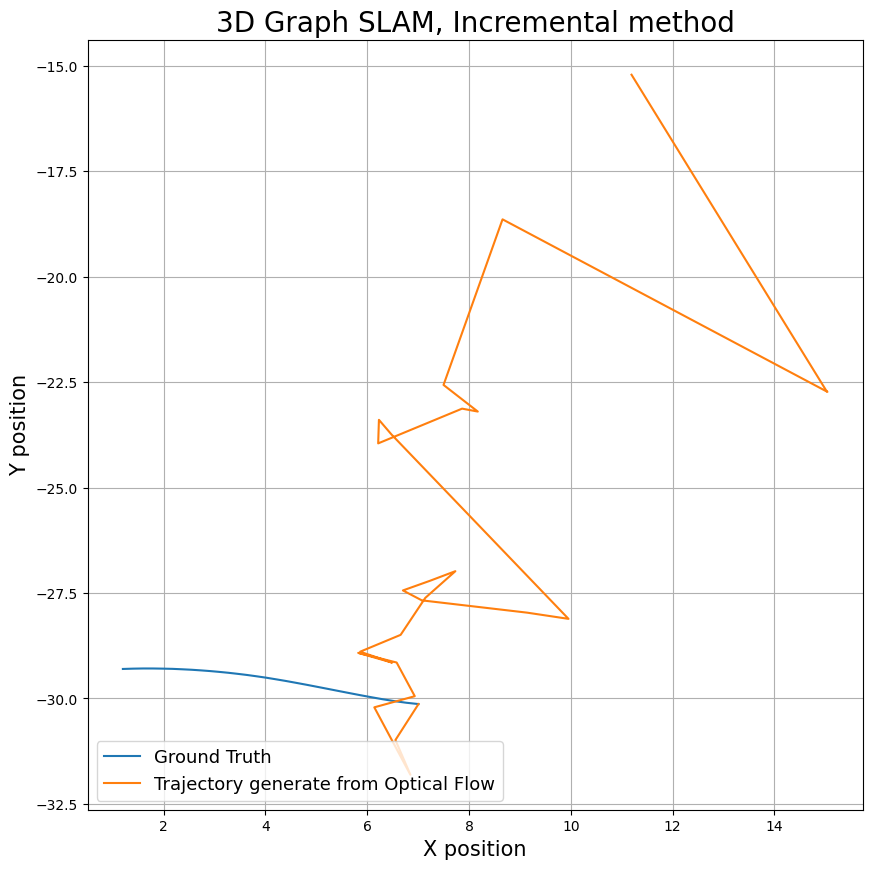

In [ ]:
###CHATGPT
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)
poses = np.loadtxt('/content/drive/MyDrive/data/pose_left.txt')
flow = np.load('/content/drive/MyDrive/data/flow_dd.npy')  # assumes flow data is stored in .flo format

for i in range(30):
    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()
    if i == 0:
        R0 = gtsam.Rot3.Quaternion(poses[i,6], poses[i,3], poses[i,4], poses[i,5])
        t0 = gtsam.Point3(poses[0,0], poses[0,1], poses[0,2])
        priorMean = gtsam.Pose3(R0, t0)
        priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))  # 30cm std on x,y,z. 0.1 rad on all angles
        graph.push_back(gtsam.PriorFactorPose3(i, priorMean, priorNoise)) 
        initialEstimate.insert(i, priorMean)
    else:
        initialEstimate.insert(i, result.atPose3(i-1))
        for j in range(29):
            if j+1 == i:
                m = j
                n = j+1
                du = flow[i, :, :, 0]/640
                dv = flow[i, :, :, 1]/480
                pts1 = np.vstack((du.flatten(), dv.flatten()))
                pts2 = pts1 + np.array([[1], [0]])  # create second set of points shifted by (1, 0)

                # Compute essential matrix using eight-point algorithm
                pts1_norm = np.linalg.inv(K) @ np.vstack((pts1, np.ones((1, pts1.shape[1]))))
                pts2_norm = np.linalg.inv(K) @ np.vstack((pts2, np.ones((1, pts2.shape[1]))))
                E, _ = cv2.findEssentialMat(pts1_norm[:2].T, pts2_norm[:2].T, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

                # Ensure essential matrix satisfies constraint on singular values
                U, S, Vt = np.linalg.svd(E)
                S = np.array([1, 1, 0])
                E = U @ np.diag(S) @ Vt

                # Recover relative camera pose from essential matrix
                retval, R, t, _ = cv2.recoverPose(E, pts1_norm[:2].T, pts2_norm[:2].T, K)
                #R = gtsam.Rot3.Quaternion(edges[j,8], edges[j,5], edges[j,6], edges[j,7])
                #t = gtsam.Point3(edges[j,2],edges[j,3],edges[j,4])
                Rodo = gtsam.Rot3(R)
                odometry = gtsam.Pose3(Rodo,t)
                odometryNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

                graph.push_back(gtsam.BetweenFactorPose3(m, n, odometry, odometryNoise))
    isam.update(graph, initialEstimate)
    result = isam.calculateEstimate()


optimal_poses = gtsam.utilities.extractPose3(result)
fig = plt.figure(figsize=(10,10))
plt.plot(poses[0:30,0],poses[0:30,1])
plt.plot(optimal_poses[:,9], optimal_poses[:,10])
plt.xlabel("X position", fontsize = 15)
plt.ylabel("Y position", fontsize = 15)

plt.title('3D Graph SLAM, Incremental method', fontsize = 20)
plt.legend(['Ground Truth', 'Trajectory generate from Optical Flow'], fontsize = 13, loc='lower left')
plt.grid()
plt.show()


Recover visual odometry using optical flow version 2, incremental solution


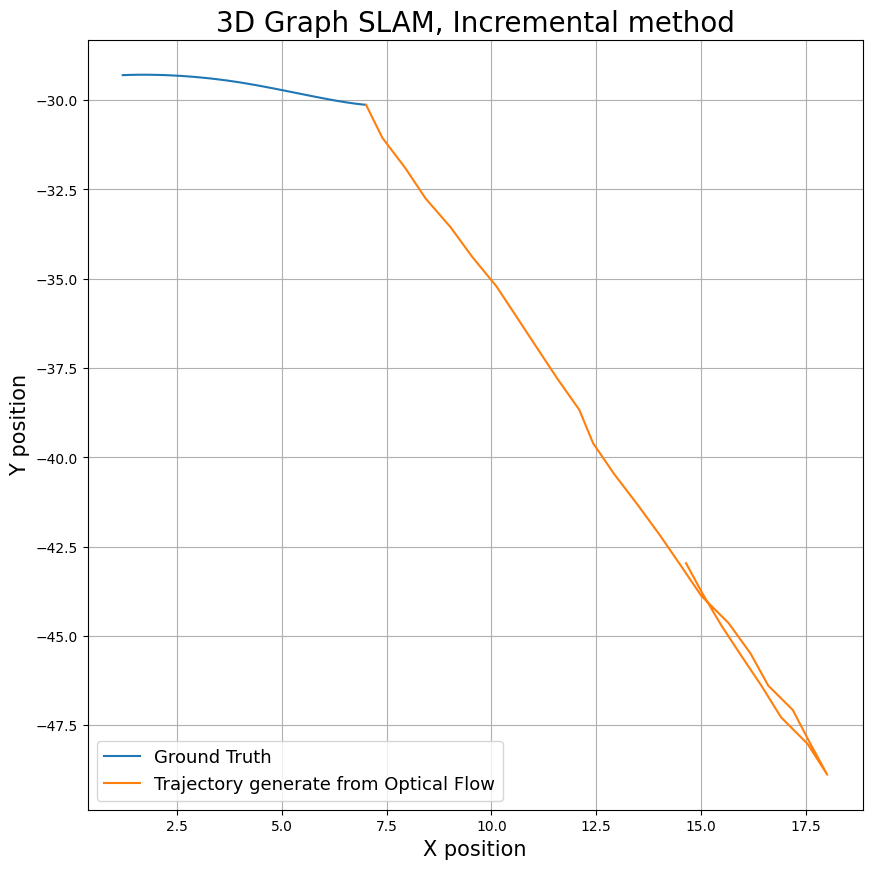

In [ ]:
###ARAVIND
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)
poses = np.loadtxt('/content/drive/MyDrive/data/pose_left.txt')
odom = np.loadtxt('/content/drive/MyDrive/data/odom.txt')

for i in range(30):
    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()
    if i == 0:
        R0 = gtsam.Rot3.Quaternion(poses[i,6], poses[i,3], poses[i,4], poses[i,5])
        t0 = gtsam.Point3(poses[0,0], poses[0,1], poses[0,2])
        priorMean = gtsam.Pose3(R0, t0)
        priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))  # 30cm std on x,y,z. 0.1 rad on all angles
        graph.push_back(gtsam.PriorFactorPose3(i, priorMean, priorNoise)) 
        initialEstimate.insert(i, priorMean)
    else:
        initialEstimate.insert(i, result.atPose3(i-1))
        for j in range(29):
            if j+1 == i:
                m = j
                n = j+1
                R = np.array([odom[i,0],odom[i,1],odom[i,2],odom[i,3],odom[i,4],odom[i,5],odom[i,6],odom[i,7],odom[i,8]]).reshape(3,3)
                t = gtsam.Point3(odom[i,9],odom[i,10],odom[i,11])
                Rodo = gtsam.Rot3(R)
                odometry = gtsam.Pose3(Rodo,t)
                odometryNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

                graph.push_back(gtsam.BetweenFactorPose3(m, n, odometry, odometryNoise))
    isam.update(graph, initialEstimate)
    result = isam.calculateEstimate()


optimal_poses = gtsam.utilities.extractPose3(result)
fig = plt.figure(figsize=(10,10))
plt.plot(poses[0:30,0],poses[0:30,1])
plt.plot(optimal_poses[:,9], optimal_poses[:,10])
plt.xlabel("X position", fontsize = 15)
plt.ylabel("Y position", fontsize = 15)

plt.title('3D Graph SLAM, Incremental method', fontsize = 20)
plt.legend(['Ground Truth', 'Trajectory generate from Optical Flow'], fontsize = 13, loc='lower left')
plt.grid()
plt.show()


Recover visual odometry using optical flow version 3, incremental solution


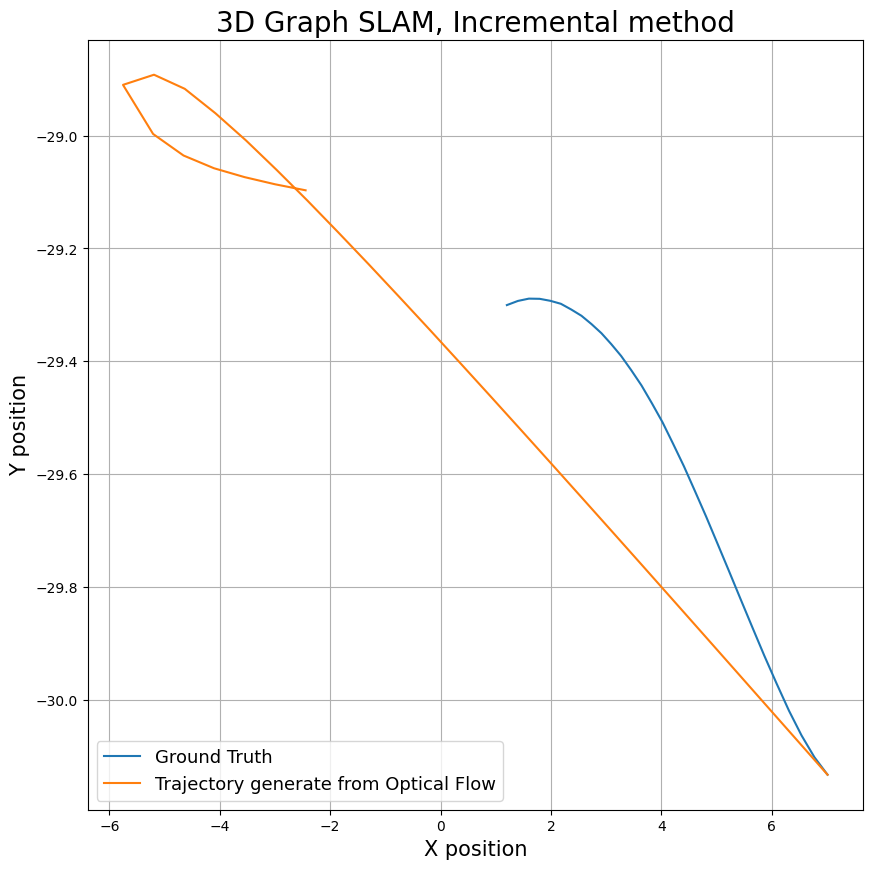

In [ ]:
###SIYUAN
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)
poses = np.loadtxt('/content/drive/MyDrive/data/pose_left.txt')
flow = np.load('/content/drive/MyDrive/data/flow_dd.npy')  # assumes flow data is stored in .flo format
depth = np.load('/content/drive/MyDrive/data/left_depth_dd.npy')

for i in range(30):
    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()
    if i == 0:
        R0 = gtsam.Rot3.Quaternion(poses[i,6], poses[i,3], poses[i,4], poses[i,5])
        t0 = gtsam.Point3(poses[0,0], poses[0,1], poses[0,2])
        priorMean = gtsam.Pose3(R0, t0)
        priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))  # 30cm std on x,y,z. 0.1 rad on all angles
        graph.push_back(gtsam.PriorFactorPose3(i, priorMean, priorNoise)) 
        initialEstimate.insert(i, priorMean)
    else:
        initialEstimate.insert(i, result.atPose3(i-1))
        for j in range(29):
            if j+1 == i:
                m = j
                n = j+1
                # normalize the optical flow values
                flow = flow.astype(np.float32)
                flow[i,:,:,0] /= 640
                flow[i,:,:,1] /= 480

                x, y = np.meshgrid(np.arange(depth[i+1,:,:].shape[1]), np.arange(depth[i+1,:,:].shape[0]))
                points3D = np.stack([x, y, depth[i+1,:,:]], axis=-1)
                points3D = points3D.reshape(-1, 3)
                points3D[:, 0] = (points3D[:, 0] - 320) / 320
                points3D[:, 1] = (points3D[:, 1] - 240) / 320

                # compute the fundamental matrix using the 8-point algorithm
                pts1 = points3D[:, :2]  # 2D points in the first image
                pts2 = pts1 + flow[i,:,:].reshape(-1, 2)  # corresponding 2D points in the second image
                F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)

                # decompose the essential matrix from the fundamental matrix
                E = np.matmul(np.matmul(K.T, F), K)
                _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
                Rodo = gtsam.Rot3(R)
                odometry = gtsam.Pose3(Rodo,t)
                odometryNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

                graph.push_back(gtsam.BetweenFactorPose3(m, n, odometry, odometryNoise))
    isam.update(graph, initialEstimate)
    result = isam.calculateEstimate()


optimal_poses = gtsam.utilities.extractPose3(result)
fig = plt.figure(figsize=(10,10))
plt.plot(poses[0:30,0],poses[0:30,1])
plt.plot(optimal_poses[:,9], optimal_poses[:,10])
plt.xlabel("X position", fontsize = 15)
plt.ylabel("Y position", fontsize = 15)

plt.title('3D Graph SLAM, Incremental method', fontsize = 20)
plt.legend(['Ground Truth', 'Trajectory generate from Optical Flow'], fontsize = 13, loc='lower left')
plt.grid()
plt.show()
